# 4.4.5 NLP Challenge using Romeo and Juliet

In [82]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import shakespeare, stopwords #,  qc

import spacy
from collections import Counter

import re
from sklearn.model_selection import train_test_split


### 1 . Data processing, cleaning, language parsing

First, taking a look at documents in shakespeare, and picking one.

In [83]:
print(shakespeare.fileids())

['a_and_c.xml', 'dream.xml', 'hamlet.xml', 'j_caesar.xml', 'macbeth.xml', 'merchant.xml', 'othello.xml', 'r_and_j.xml']


In [84]:
rj = shakespeare.raw('r_and_j.xml')
print(rj[:150])

<?xml version="1.0"?>
<?xml-stylesheet type="text/css" href="shakes.css"?>
<!-- <!DOCTYPE PLAY SYSTEM "play.dtd"> -->

<PLAY>
<TITLE>The Tragedy 


Originally I didn't know aout XML Element tree so I tried using a lot of regular expressions - a useful explanation of the specific regular expression used is [here](https://stackoverflow.com/questions/8784396/delete-the-words-between-two-delimiters-in-python) (for future reference).

However, then I found out about ElementTree, and learned a tiny bit about parsing with it. Here are some tutorials that I am still looking at: [this one from effbott](http://effbot.org/zone/element.htm), and [the python docs](https://docs.python.org/3.5/library/xml.etree.elementtree.html), [datacamp](https://www.datacamp.com/community/tutorials/python-xml-elementtree), [nltk](https://www.nltk.org/book/ch11.html).

In [85]:
import xml.etree.ElementTree as ET

tree = ET.parse('/Users/gemma/nltk_data/corpora/shakespeare/r_and_j.xml')
root = tree.getroot()

Taking a look at the categories of elements:

In [86]:
set([elem.tag for elem in root.iter()])

{'ACT',
 'FM',
 'GRPDESCR',
 'LINE',
 'P',
 'PERSONA',
 'PERSONAE',
 'PGROUP',
 'PLAY',
 'PLAYSUBT',
 'PROLOGUE',
 'SCENE',
 'SCNDESCR',
 'SPEAKER',
 'SPEECH',
 'STAGEDIR',
 'TITLE'}

Gaining an understanding of the structure of the document / tree:

In [87]:
#parent_map = dict((c, p) for p in tree.getiterator() for c in p)

#for key in parent_map:
#    if key.text:
#        print("key tag:  ", key.tag, " key text: ", key.text, " parent tag: ", parent_map[key].tag, " parent text: ", 
#             parent_map[key].text)

Next we will extract the elements of interest and put them in a dataframe.

At the same time, I'll clean up the lines using the below function, as we go, for the sake of efficiency.

In [7]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [8]:
# trying to get all of the speakers and their lines in an array

rows = {}

l = 0 

for i, act in enumerate(root.findall('ACT')):
    for s, act_t in enumerate(act.findall('TITLE')):
        print(act_t.text)
    for j, scene in enumerate(act.findall('SCENE')):
        for q, scene_t in enumerate(scene.findall('TITLE')):
            print(scene_t.text)
            only_number = scene_t.text.split('.',1)
        for k, speech in enumerate(scene.findall('SPEECH')):
            for i, speaker in enumerate(speech.findall('SPEAKER')):
                
                # there is an instance of LADY  CAPULET which shouldbe LADY CAPULET
                if speaker.text == 'LADY  CAPULET':
                    speaker.text = speaker.text.replace('LADY  CAPULET', 'LADY CAPULET')
                
                all_lines = []
                for line in speech.findall('LINE'):
                    if line.text:
                        line.text = text_cleaner(line.text)
                        all_lines.append(line.text)
                
                rows[l] = ([act_t.text, only_number[0], only_number[1], speaker.text, ' '.join(all_lines)])
                l+=1


ACT I
SCENE I.  Verona. A public place.
SCENE II.  A street.
SCENE III.  A room in Capulet's house.
SCENE IV.  A street.
SCENE V.  A hall in Capulet's house.
ACT II
SCENE I.  A lane by the wall of Capulet's orchard.
SCENE II.  Capulet's orchard.
SCENE III.  Friar Laurence's cell.
SCENE IV.  A street.
SCENE V.  Capulet's orchard.
SCENE VI.  Friar Laurence's cell.
ACT III
SCENE I.  A public place.
SCENE II.  Capulet's orchard.
SCENE III.  Friar Laurence's cell.
SCENE IV.  A room in Capulet's house.
SCENE V.  Capulet's orchard.
ACT IV
SCENE I.  Friar Laurence's cell.
SCENE II.  Hall in Capulet's house.
SCENE III.  Juliet's chamber.
SCENE IV.  Hall in Capulet's house.
SCENE V.  Juliet's chamber.
ACT V
SCENE I.  Mantua. A street.
SCENE II.  Friar Laurence's cell.
SCENE III.  A churchyard; in it a tomb belonging to the Capulets.


In [9]:
df = pd.DataFrame.from_dict(data=rows, orient='index', columns=['Act', 'Scene', 'Scene_Name','Speaker', 'Line'])

df.head()

,Act,Scene,Scene_Name,Speaker,Line
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals."
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers."
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw."
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ..."
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved."


Next, let's parse the lines in a new column with spacy.

In [10]:
# first let me make sure this will work

nlp = spacy.load('en_core_web_lg')

testing = nlp(df.loc[1, 'Line'])

for token in testing:
    print(token.lemma_)

no
,
for
then
-PRON-
should
be
collier
.


In [11]:
# it worked! let's apply it to the whole dataframe of lines

df['parsed'] = df['Line'].apply(nlp)

In [12]:
df.head()

,Act,Scene,Scene_Name,Speaker,Line,parsed
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals.","(Gregory, ,, o, ', my, word, ,, we, 'll, not, ..."
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers.","(No, ,, for, then, we, should, be, colliers, .)"
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw.","(I, mean, ,, an, we, be, in, choler, ,, we, 'l..."
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ...","(Ay, ,, while, you, live, ,, draw, your, neck,..."
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved.","(I, strike, quickly, ,, being, moved, .)"


In [13]:
# double checking that LADY  CAPULET was replaced w correctly spaced name
df[df['Speaker'] == 'LADY  CAPULET']

,Act,Scene,Scene_Name,Speaker,Line,parsed


### 2. Creating features using two different NLP methods, BOW and tf-idf

**a. BOW**

In order to get a list of the common words from the text, first I'm going to put all the lines together into one text (one string) and then run spaCy on the resulting text. This is a little redundant since I already ran spaCy on each individual line, but it is the best way I could think of to keep the lines organized by speaker in the dataframe.

In [14]:
all_the_lines = []

# just look at "LINE"s in the tree
for line in root.iter('LINE'):
    # make sure it's a string (ignore the "None" entries)
    if isinstance(line.text, str):
        all_the_lines.append(line.text)
    
complete_doc = nlp((' '.join(all_the_lines)))

Then I'll use the bag of words function to get the most common words across all of the lines.

In [15]:
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]

In [16]:
common_words = bag_of_words(complete_doc)

Add the common words as word counts in the dataframe:

In [17]:
def bow_features(original_df, common_words):
    
    # copy the dataframe so your bow features will be in a new one and wont affect the original data
    df = original_df.copy(deep=True)
    
    # Add the words to the dataframe and set all counts to 0
    for word in common_words:
        df[word] = 0
        
    # Process each row, counting the occurrence of words in each parsed sentence.
    for i, sentence in enumerate(df['parsed']):
        
        # I already converted the sentence to lemmas, and filtered out punctuation and stop words.
        # Now I'm just going to get a list of the words in each line that are in the common words list.
        words = [token.lemma_
                 for token in sentence
                 if token.lemma_ in common_words
                ]
        
        # Populate the row with word counts
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

In [18]:
df_plus_bow = bow_features(df,common_words)

Processing row 0
Processing row 500


In [19]:
df_plus_bow.head()

,Act,Scene,Scene_Name,Speaker,Line,parsed,-PRON-,be,and,the,...,hatred,intercession,stead,plain,homely,plainly,woo'd,forsake,maria,brine
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals.","(Gregory, ,, o, ', my, word, ,, we, 'll, not, ...",2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers.","(No, ,, for, then, we, should, be, colliers, .)",1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw.","(I, mean, ,, an, we, be, in, choler, ,, we, 'l...",3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ...","(Ay, ,, while, you, live, ,, draw, your, neck,...",2,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved.","(I, strike, quickly, ,, being, moved, .)",1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


We will use the bow features in a model soon, but first I'll create the features using df-idf.

**b. df-idf**

Let's take a look at the dataframe again.

In [20]:
df.head()

,Act,Scene,Scene_Name,Speaker,Line,parsed
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals.","(Gregory, ,, o, ', my, word, ,, we, 'll, not, ..."
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers.","(No, ,, for, then, we, should, be, colliers, .)"
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw.","(I, mean, ,, an, we, be, in, choler, ,, we, 'l..."
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ...","(Ay, ,, while, you, live, ,, draw, your, neck,..."
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved.","(I, strike, quickly, ,, being, moved, .)"


It looks ready to run the model, so let's go to the next step.

### 3. Supervised learning models

Using the different sets of features from above. First let's use bow with random forest and see if we can predict the speaker.

a. **BOW** 

<em>i. with Random Forest</em>

In [21]:
from sklearn import ensemble

In [22]:
rfc = ensemble.RandomForestClassifier()
Y = df_plus_bow['Speaker']
X = df_plus_bow.drop(['Act','Scene', 'Scene_Name','Speaker', 'Line', 'parsed'], 1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9840954274353877

Test set score: 0.17261904761904762


In [23]:
from sklearn.model_selection import cross_val_score

validate = cross_val_score(rfc, X_test, y_test, cv=10)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


The warning shows a problem with the number of members in each class, meaning in this case the number of lines for some of the speakers. Let's see if we can drop speakers with less than a certain threshold of lines.

In [24]:

# get the counts of each speaker and add it as a column
df_plus_bow['Speaker_counts'] = df_plus_bow.groupby('Speaker')['Line'].transform('count')

# drop lines whose speakers have less than 10 lines from the rows
df_plus_bow_max = df_plus_bow.drop(df_plus_bow[df_plus_bow.Speaker_counts < 10].index)

In [25]:
# double check it worked 
df_plus_bow_max.groupby('Speaker')['Speaker_counts'].count().sort_values(ascending=False)

Speaker
ROMEO             163
JULIET            118
Nurse              89
BENVOLIO           64
MERCUTIO           62
FRIAR LAURENCE     55
CAPULET            50
LADY CAPULET       45
PARIS              23
SAMPSON            20
TYBALT             17
PRINCE             16
GREGORY            15
PETER              13
BALTHASAR          12
Servant            10
MONTAGUE           10
Name: Speaker_counts, dtype: int64

In [26]:
# re run rfc

rfc = ensemble.RandomForestClassifier()
Y_max = df_plus_bow_max['Speaker']
X_max = df_plus_bow_max.drop(['Act','Scene', 'Scene_Name','Speaker', 'Line', 'parsed', 'Speaker_counts'], 1)

X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max, 
                                                    Y_max,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train_max, y_train_max)

print('Training set score:', rfc.score(X_train_max, y_train_max))
print('\nTest set score:', rfc.score(X_test_max, y_test_max))

Training set score: 0.9850746268656716

Test set score: 0.19169329073482427


In [27]:
validate = cross_val_score(rfc, X_train_max, y_train_max, cv=5)

In [28]:
print(validate)
print(np.mean(validate), '+/-', np.std(validate)*2)

[0.2038835  0.17708333 0.15957447 0.15909091 0.18181818]
0.17629007749463232 +/- 0.033079406060104434


In [29]:
print("Accuracy: %0.2f (+/- %0.2f)" % (validate.mean(), validate.std() * 2))

Accuracy: 0.18 (+/- 0.03)


<em>ii. with Logistic Regression</em>

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(503, 2000) (503,)
Training set score: 0.9502982107355865

Test set score: 0.23809523809523808


In [32]:
validate_lr = cross_val_score(lr, X_train_max, y_train_max, cv=5)

In [33]:
print("Accuracy: %0.2f (+/- %0.2f)" % (validate_lr.mean(), validate_lr.std() * 2))

Accuracy: 0.27 (+/- 0.04)


<em>iii. with Gradient Boosting</em>

In [34]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.9701789264413518

Test set score: 0.24404761904761904


In [35]:
validate_gb = cross_val_score(clf,X_train_max,y_train_max,cv=5)

In [36]:
print("Accuracy: %0.2f (+/- %0.2f)" % (validate_gb.mean(), validate_gb.std() * 2))

Accuracy: 0.23 (+/- 0.03)


**b. tf-idf**

Next we'll run the tf-idf vectorizer to get the vectors for each line. Normally this is on a paragraph basis but since this is a play lines should be a good substitute.

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(df['Line'], test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.75, # drop words that occur in more than 75 percent of the paragraphs
                             min_df=3, # only use words that appear at least 3 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
lines_tfidf=vectorizer.fit_transform(df['Line'])
print("Number of features: %d" % lines_tfidf.get_shape()[1])

# inititally tried model with parameters: max_df 0.75, min_df 10, # of features was 187

Number of features: 796


In [38]:

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(lines_tfidf, test_size=0.4, random_state=0)

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was
# present once in that sentence.
print('Original sentence:', X_train[0])
print('Tf_idf vector:', tfidf_bypara[0])

Original sentence: Gregory, o' my word, we'll not carry coals.
Tf_idf vector: {'laurence': 0.41324507177540226, 'friar': 0.336058721652412, 'gone': 0.6486787186462298, 'daughter': 0.3673003861933039, 'time': 0.31424202170388116, 'shall': 0.2486993050410113}


<em>Dimension reduction</em>

In [39]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space.
svd= TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 98.96534125594387
Component 0:
Line
Thou know'st the mask of night is on my face, Else would a maiden blush bepaint my cheek For that which thou hast heard me speak to-night Fain would I dwell on form, fain, fain deny What I have spoke: but farewell compliment! Dost thou love me? I know thou wilt say 'Ay,' And I will take thy word: yet if thou swear'st, Thou mayst prove false; at lovers' perjuries Then say, Jove laughs. O gentle Romeo, If thou dost love, pronounce it faithfully: Or if thou think'st I am too quickly won, I'll frown and be perverse an say thee nay, So thou wilt woo; but else, not for the world. In truth, fair Montague, I am too fond, And therefore thou mayst think my 'havior light: But trust me, gentleman, I'll prove more true Than those that have more cunning to be strange. I should have been more strange, I must confess, But that thou overheard'st, ere I was ware, My true love's passion: therefore pardon me, And not impute t

<em>Sentence similarity with latent semantic analysis</em>

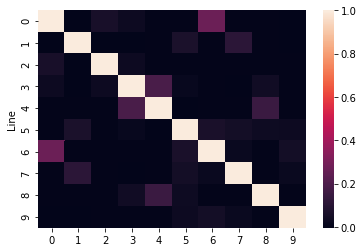

Key:
0 Go, be gone. We shall be much unfurnished for this time. What, is my daughter gone to Friar Laurence?
1 Give me the letter; I will look on it. Where is the county's page, that raised the watch? Sirrah, what made your master in this place?
2 Patience perforce with wilful choler meeting Makes my flesh tremble in their different greeting. I will withdraw: but this intrusion shall Now seeming sweet convert to bitter gall.
3 No, 'tis not so deep as a well, nor so wide as a church-door; but 'tis enough,'twill serve: ask for me to-morrow, and you shall find me a grave man. I am peppered, I warrant, for this world. A plague o' both your houses! 'Zounds, a dog, a rat, a mouse, a cat, to scratch a man to death! a braggart, a rogue, a villain, that fights by the book of arithmetic! Why the devil came you between us? I was hurt under your arm.
4 'Tis more, 'tis more, his son is elder, sir; His son is thirty.
5 I hear some noise. Lady, come from that nest Of death, contagion, and unnatural s

In [40]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])


### 4. Assess your models using cross-validation and determine whether one model performed better.



In [41]:
order = ['random forest', 'logistic regression', 'gradient boosting']

models = pd.DataFrame(index=order)

models['training'] = [0.9880715705765407, 0.9463220675944334, 0.9681908548707754]
models['testing'] = [0.16071428571428573,0.23809523809523808, 0.22916666666666666]
models['cross_val_acc'] = ['0.16 (+/- 0.13)','0.27 (+/- 0.04)','0.23 (+/- 0.03)']

models

,training,testing,cross_val_acc
random forest,0.988072,0.160714,0.16 (+/- 0.13)
logistic regression,0.946322,0.238095,0.27 (+/- 0.04)
gradient boosting,0.968191,0.229167,0.22 (+/- 0.03)


It looks like logistic regression scored better in testing and the cross validation, though gradient boosting and random forest were both better then it on the training set - which sounds a lot like overfitting. Therefore the model that performed the best on the BOW features was the **logistic regression**.

### 5. Pick one of the models and try to increase accuracy by at least 5 percentage points.

Let's try to improve the logistic regression model with the BOW features, since that one performed the best. First, let's take another look at the data.

In [42]:
df_plus_bow.head()

,Act,Scene,Scene_Name,Speaker,Line,parsed,-PRON-,be,and,the,...,intercession,stead,plain,homely,plainly,woo'd,forsake,maria,brine,Speaker_counts
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals.","(Gregory, ,, o, ', my, word, ,, we, 'll, not, ...",2,0,0,0,...,0,0,0,0,0,0,0,0,0,20
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers.","(No, ,, for, then, we, should, be, colliers, .)",1,1,0,0,...,0,0,0,0,0,0,0,0,0,15
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw.","(I, mean, ,, an, we, be, in, choler, ,, we, 'l...",3,1,0,0,...,0,0,0,0,0,0,0,0,0,20
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ...","(Ay, ,, while, you, live, ,, draw, your, neck,...",2,0,0,1,...,0,0,0,0,0,0,0,0,0,15
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved.","(I, strike, quickly, ,, being, moved, .)",1,1,0,0,...,0,0,0,0,0,0,0,0,0,20


### <em>feature engineering</em>

For features, we'll use Act and Scene. I'll add some more features too - first, word count.

In [43]:
df_plus_bow['word_count'] = len(df['parsed'])

Let's also add a count of the unique parts of speech in each sentence.

In [44]:
def unique_pos(Series):
    
    allpos = [token.pos_ for token in Series]
        
    return (len(set(allpos)))

In [67]:
df_plus_bow['unique_pos'] = df_plus_bow['parsed'].apply(unique_pos)

Let's try and use word vectors on the sentence level.

In [46]:
# First I'm double checking that all of the words in the doc have vectors already.

count = 0
for token in complete_doc:
    if token.has_vector:
        count+=1
    
print(len(complete_doc), count)


30085 29678


In [68]:
import re 

# couldnt search complete_doc so rejoined the lines to search through w/ regular expression
okay_again = ' '.join(all_the_lines)


def get_vector(value):
    
    # get the location of the sentence in the nlp loaded text

    target = re.compile(value)
    
    # find the target in complete_doc and return it as an itme
    found = target.search(okay_again)
    
    if found != None:
    
        # beginning and end
        start = found.start()
        end = found.end()
    
        span = complete_doc[start:end]
        
        if span.has_vector:
            return span.vector_norm
        else:
            return 0
    else:
        return 0

df_plus_bow['vector'] = df_plus_bow['Line'].apply(get_vector)

In [69]:
df_plus_bow.head()

,Act,Scene,Scene_Name,Speaker,Line,parsed,-PRON-,be,and,the,...,homely,plainly,woo'd,forsake,maria,brine,Speaker_counts,word_count,unique_pos,vector
0,ACT I,SCENE I,Verona. A public place.,SAMPSON,"Gregory, o' my word, we'll not carry coals.","(Gregory, ,, o, ', my, word, ,, we, 'll, not, ...",2,0,0,0,...,0,0,0,0,0,0,20,839,8,3.022147
1,ACT I,SCENE I,Verona. A public place.,GREGORY,"No, for then we should be colliers.","(No, ,, for, then, we, should, be, colliers, .)",1,1,0,0,...,0,0,0,0,0,0,15,839,7,3.289926
2,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I mean, an we be in choler, we'll draw.","(I, mean, ,, an, we, be, in, choler, ,, we, 'l...",3,1,0,0,...,0,0,0,0,0,0,20,839,6,3.212513
3,ACT I,SCENE I,Verona. A public place.,GREGORY,"Ay, while you live, draw your neck out o' the ...","(Ay, ,, while, you, live, ,, draw, your, neck,...",2,0,0,1,...,0,0,0,0,0,0,15,839,9,3.014298
4,ACT I,SCENE I,Verona. A public place.,SAMPSON,"I strike quickly, being moved.","(I, strike, quickly, ,, being, moved, .)",1,1,0,0,...,0,0,0,0,0,0,20,839,4,3.084016


In [77]:
# convert act and scene to numbers

def get_numeric(name):
    
    roman = {'IV' : 4, 'V': 5, 'VI' : 6, 'VII' : 7}
    
    pieces = name.split()
    if 'V' not in pieces[1]:
        return len(pieces[1])
    else:
        return roman[pieces[1]]

df['Act_num'] = df['Act'].apply(get_numeric)
df['Scene_num'] = df['Scene'].apply(get_numeric)

### <em>fitting the logistic model</em>
    

In [78]:
# 1. getting the testing and training samples

Y_new_f = df_plus_bow_max['Speaker']
X_new_f = df_plus_bow_max.drop(['Act','Scene', 'Scene_Name', 'Speaker', 'Line', 'parsed'], 1)

X_train_new_f, X_test_new_f, y_train_new_f, y_test_new_f = train_test_split(X_new_f, 
                                                    Y_new_f,
                                                    test_size=0.4,
                                                    random_state=0)

In [79]:
lr = LogisticRegression()
lr.fit(X_train_new_f, y_train_new_f)
print(X_train_new_f.shape, y_train_new_f.shape)
print('Training set score:', lr.score(X_train_new_f, y_train_new_f))
print('\nTest set score:', lr.score(X_test_new_f, y_test_new_f))

(469, 2001) (469,)
Training set score: 0.9744136460554371

Test set score: 0.4249201277955272


In [80]:
validate_lr2 = cross_val_score(lr, X_train_new_f, y_train_new_f, cv=5)


In [81]:
print("Accuracy: %0.2f (+/- %0.2f)" % (validate_lr2.mean(), validate_lr2.std() * 2))

Accuracy: 0.45 (+/- 0.07)
